## This notebook reads in 2.5&deg; NCEP-NCAR reanalysis data from the DAES THREDDS repository, and plots 250-hPa isotachs, heights, and ageostrophic wind barbs for a specified date range.

#### A basic template is provided as a starting point. This script will work provided that you fill in the blanks correctly, in every place there's a "FILL HERE" written. This script also makes use of various metpy diagnostics and units - refer to the following links for reference:

https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html

https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html

https://unidata.github.io/python-gallery/examples/index.html
    
#### Also refer to the following ATM 350 sample code plotting frontogenesis and calculating divergence:
/spare11/atm350/common/apr04/04_GriddedDiagnostics_Frontogenesis-CFSR.ipynb
/spare11/atm350/commom/apr04/03_GriddedDiagnostics_DivergenceIsotachs-CFSR.ipynb

In [57]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import num2date
from pyproj import Proj
import datetime as dt
from time import gmtime, strftime, strptime, localtime
import cartopy
from cartopy import crs as ccrs
from cartopy import feature as cfeat
from cartopy import util as cu
from scipy.ndimage import gaussian_filter
import metpy.calc as diag
from metpy.units import units
%matplotlib inline

In [58]:
#mpl.rcParams.keys()
mpl.rcParams['lines.linestyle'] = 'solid'

## Step 1 - Read in NCEP-NCAR data

This dataset is provided through the DAES THREDDS server in a monthly format (link provided below). The data is stored in GEMPAK (.gem) format, but the underlying netCDF-Java library translates this to netCDF format as we are reading this from an OpenDAP server (THREDDS).

http://thredds.atmos.albany.edu:8080/thredds/catalog/NCEP_NCAR/catalog.html

In [59]:
#Provide start & end dates in YYYYMMDD/HH format (e.g., 19930314/00)
start_date = '19930314/00' #FILL HERE
end_date = '19930314/00' #FILL HERE

#Provide increment intervals in hours
interval_hours = 24 #FILL HERE

#====================================================================================

#Convert the start & end dates specified above to datetime objects
#Note we add the interval_hours to the end date as np.arange() creates a range up to *but not including* the end of the range
interval_hours = dt.timedelta(hours=interval_hours)
sdate = dt.datetime.strptime(start_date,'%Y%m%d/%H')
edate = dt.datetime.strptime(end_date,'%Y%m%d/%H') + interval_hours

#Load in handle to the data for the specified month
yyyymm = dt.datetime.strftime(sdate,'%Y%m')
data = data = xr.open_dataset("http://thredds.atmos.albany.edu:8080/thredds/dodsC/NCEP_NCAR/%s.gem" % (yyyymm))

#### Check the content of the file:

#### Keep in mind that each data source will typically have a different notation for coordinates (e.g., latitude, longitude, time, pressure) and variable names (e.g., temperature, u-wind). Check the content of the file to see the names you'll need to use later on:

In [60]:
data

<xarray.Dataset>
Dimensions:          (time: 124, lat: 73, lon: 144, HGHT: 3, MWSL: 1, PDLY: 1,
                      bounds_dim: 2, PRES1: 12, PRES: 17, PRES2: 8, SGMA1: 1,
                      SGMA: 4, TROP: 1)
Coordinates:
  * time             (time) datetime64[ns] 1993-03-01 ... 1993-03-31T18:00:00
  * lat              (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * lon              (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * HGHT             (HGHT) float64 1.829e+03 2.743e+03 3.658e+03
  * MWSL             (MWSL) float64 0.0
  * PDLY             (PDLY) float64 15.0
  * PRES1            (PRES1) float64 1e+03 925.0 850.0 ... 200.0 150.0 100.0
  * PRES             (PRES) float64 1e+03 925.0 850.0 700.0 ... 30.0 20.0 10.0
  * PRES2            (PRES2) float64 1e+03 925.0 850.0 ... 500.0 400.0 300.0
  * SGMA1            (SGMA1) float64 9.95e+03
  * SGMA             (SGMA) float64 4.974e+03 5.8e+03 7.2e+03 8.3e+03
  * TROP             (TROP) float64 0.0
Dimensions without coordinates: bounds_dim
Data variables: (12/38)
    latLonCoordSys   |S64 ...
    PDLY_bounds      (PDLY, bounds_dim) float64 ...
    SGMA_bounds      (SGMA, bounds_dim) float64 ...
    TMPK_PRES        (time, PRES, lat, lon) float32 ...
    TMPK_MWSL        (time, MWSL, lat, lon) float32 ...
    TMPK_PDLY_layer  (time, PDLY, lat, lon) float32 ...
    ...               ...
    VREL_TROP        (time, TROP, lat, lon) float32 ...
    PWTR_NONE        (time, lat, lon) float32 ...
    HGHT_PRES        (time, PRES, lat, lon) float32 ...
    HGHT_NONE        (time, lat, lon) float32 ...
    LFT4_NONE        (time, lat, lon) float32 ...
    VWSH_TROP        (time, TROP, lat, lon) float32 ...
Attributes:
    Conventions:              CF-1.4
    title:                    GRID data
    history:                  Direct read of GEMPAK into NetCDF-Java 4 API
    featureType:              GRID
    file_format:              GEMPAK
    location:                 /ncep/ncep_ncar/199303.gem
    _CoordinateModelRunDate:  1993-03-01T00:00:00Z
    DODS.strlen:              0

Plotting time stamp 1993-03-14 00:00:00


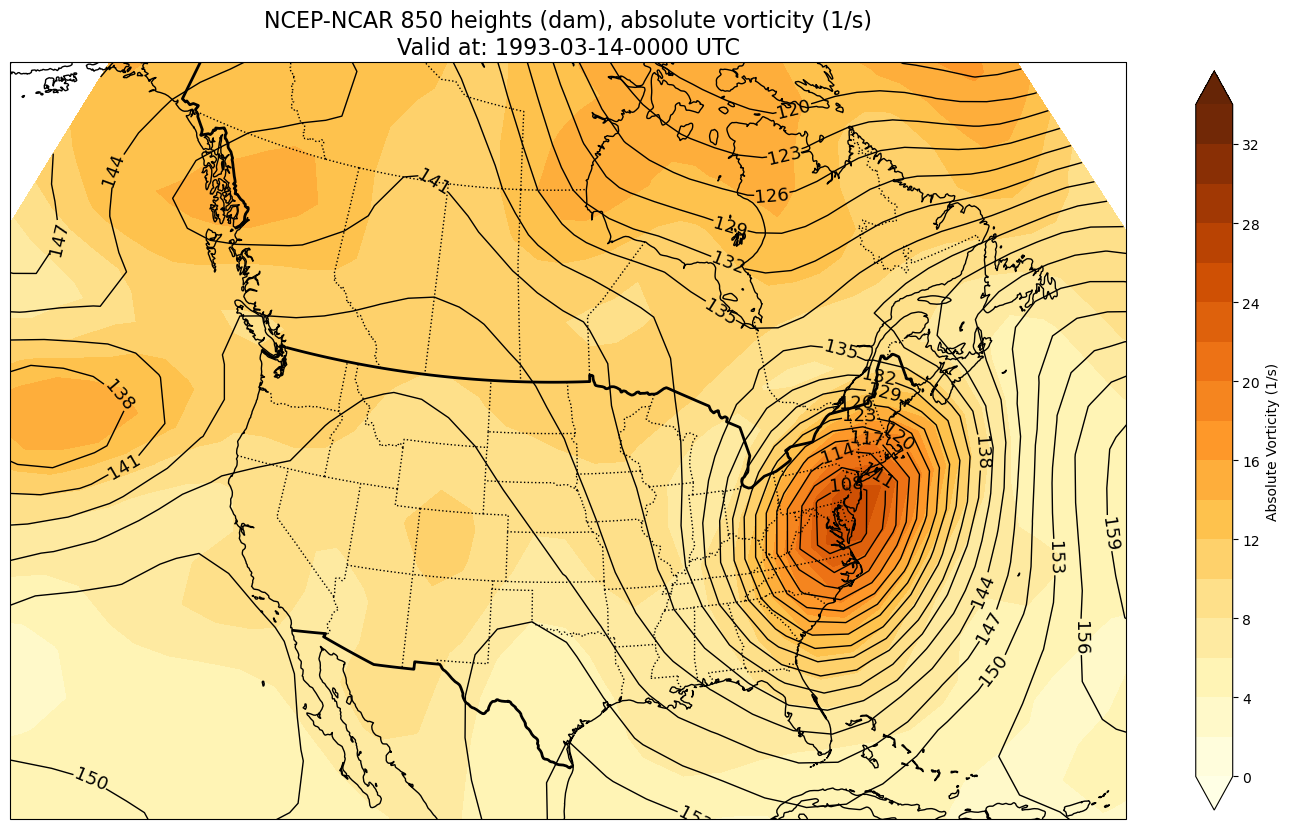

In [61]:
## Step 2: Create Cartopy object & subset data spatially & temporally

#Now that we have a handle to the data, let's create a Cartopy object to plot the data with, and subset the data spatially & temporally to reduce the memory footprint.

#Create a Lambert conformal projection object, centered over the US
lon1 = -98.5
lat1 = 38.
slat = 38.
proj_lcc = ccrs.LambertConformal(central_longitude=lon1,
                             central_latitude=lat1,
                             standard_parallels=[slat])

#Define geographic bounds for plot & data subsetting (this domain covers North America)
lonW,lonE,latS,latN = [-150+360, -45+360, 15, 70]

#Choose pressure level
level = 850 #FILL HERE

#Subset data by time, pressure level, latitude & longitude
#Hint: You'll want to create a range of latitudes and longitudes using the geographic bounds defined above
dates = np.arange(sdate,edate,interval_hours) #Create a range of dates using the time interval previously specified
data_subset = data.sel(time=dates,PRES=level,lat=slice(latS,latN),lon=slice(lonW,lonE))

#Check the content of the subset data array to ensure it's what we want
#Output below should contain 3 dimensions (time, latitude, longitude)
data_subset

## Step 3: Loop through data & generate plots

#Loop through the subset data object and generate the desired plot for each time step.

#Get lats, lons, and time steps for the subset data
#Recall from ATM 350 that you load variables into memory by adding ".values"
#(e.]pg., to load a variable called "temp", type "data_subset.temp.values")
lat = data_subset.lat.values
lon = data_subset.lon.values
times = pd.to_datetime(data_subset.time.values)

#Loop through date range
for time_step in times:
    
    #Check current time stamp
    print(f"Plotting time stamp {time_step}")
    
    #Create figure and axis
    fig = plt.figure(figsize=(18,12))
    ax = fig.add_subplot(1,1,1,projection=proj_lcc)
    ax.set_extent([lonW+18,lonE-18,latS+4,latN-7])
    
    #Add geography features (coastlines, countries, states, etc.)
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
    state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                             name='admin_1_states_provinces_lines',
                             scale='50m', facecolor='none')
    ax.add_feature(state_boundaries, linestyle=':',linewidths=1,edgecolor='black')
    
    #======================================================================================
    # 1. Load in desired variables
    #======================================================================================
    
    #Our subset data array has 3 dimensions, but we want a 2D array for plotting data spatially.
    #Create handles to our desired variables valid for the current time step we're iterating through
    u = data_subset.UREL_PRES.sel(time=time_step)
    v = data_subset.VREL_PRES.sel(time=time_step)
    g = data_subset.HGHT_PRES.sel(time=time_step)
    
    #Load each variable into memory & assign it metpy units (m/s for wind and m for height)
    u = u.values * units('m/s')
    v = v.values * units('m/s')
    g = g.values * units('dam')

    
    #======================================================================================
    # 2. 250-hPa Isotachs in filled contours
    #======================================================================================
    
    #Calculate wind speed using u & v (hint: use metpy's "wind_speed" function)]
    #wind = diag.wind_speed(u,v)
    #wind
    
    #Plot wind speed & add color bar
    #fint = np.arange(45,95,5)
    #CF = ax.contourf(lon,lat,wind,levels=fint,cmap=plt.get_cmap('turbo'),transform=ccrs.PlateCarree(),extend='max')
    #cbar = fig.colorbar(CF,shrink=0.8)

    
    #======================================================================================
    # 3. 850-hPa Heights in solid contours
    #======================================================================================

    #Convert height from m to dam
    height = g/10

            
    #Plot height contours & labels
    cint = np.arange(0,200,3)
    CS = ax.contour(lon,lat,height,cint,linewidths=1,colors='black',linestyles='solid',transform=ccrs.PlateCarree())
    ax.clabel(CS, inline=1, fontsize=13,fmt='%.0f')

    
    #===============================================================================================
    # 4. 850-hPa Geopotential Heights (solid contours) and Geostrophic Absolute Vorticity (filled)
    #===============================================================================================

    """
    Use metpy to calculate ageostrophic wind.
    
    You'll want to use metpy's "ageostrophic_wind" function, and calculate the coriolis parameter for
    each gridpoint as well as the horizontal grid spacing. Refer to your ATM 350 lecture notes for past examples with
    metpy diagnostics for gridded data.
    
    A comprehensive list of metpy diagnostic functions & handling units is available here:
    https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html
    https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html?highlight=units
    https://unidata.github.io/python-gallery/examples/index.html
    
    For calculating Coriolis, you'll need a 2D latitude array in radians (instead of degrees). This has been provided below.
    """
    
    #Convert 1D latitude and longitude arrays to 2 dimensions
    lon2d,lat2d = np.meshgrid(lon,lat)
    
    #Convert the latitude array from degrees to radians such that it can be used to calculate coriolis.
    lat2d_for_coriolis = np.radians(lat2d)
    
    #Calculate the coriolis force at all gridpoints, and horizontal distance between gridpoints
    coriolis = diag.coriolis_parameter(np.radians(lat2d))
    dx,dy = diag.lat_lon_grid_deltas(lon,lat)
    
    #Calculate ageostrophic wind
    #ua, va = diag.ageostrophic_wind(height, u, v, dx, dy, lat2d_for_coriolis)
    #ua, va
    
    #Calculate geostrophic wind
    geostrophic_wind = diag.geostrophic_wind(g, dx, dy, lat2d_for_coriolis)
    
    absolutevorticity = diag.absolute_vorticity(u, v, dx, dy, lat2d_for_coriolis) * 1e5
    
    fint = np.arange(0,35,2)
    
    CF_absolutevorticity = ax.contourf(lon, lat, absolutevorticity, fint, cmap=plt.get_cmap('YlOrBr'), transform=ccrs.PlateCarree(), extend='both')
    
    cbar_absolutevorticity = fig.colorbar(CF_absolutevorticity, shrink=0.8, label='Absolute Vorticity (1/s)')
    
    #Plot wind barbs
    #Tip: In your ATM 350 notes, you added a skip criteria such that the plot isn't populated by too many gridpoints, as the
    #CFSR is a relatively high resolution model. Since the NCEP-NCAR reanalysis has a coarse resolution, this isn't needed
    #here as the horizontal spacing between each gridpoint is fairly large.
    #ax.barbs(lon, lat, ua.m, va.m, transform=ccrs.PlateCarree(), length=6,zorder=4)
    
    #======================================================================================
    # 5. Add plot title & save figure
    #======================================================================================
    
    #Create plot title
    valTime = time_step.strftime("%Y-%m-%d-%H%M UTC")
    tl1 = str("NCEP-NCAR " + str(level)+ " heights (dam), absolute vorticity (1/s)")
    tl2 = str('Valid at: '+valTime)
    plt.title(tl1+'\n'+tl2,fontsize=16)
    
    #Save or show figure
    fname = time_step.strftime("%Y%m%d%H")
    plt.savefig(fname,dpi=125)
    plt.show()
    
    #Close figure
    plt.close()

#Close the handle to the data
data.close()

Plotting time stamp 1993-03-14 00:00:00


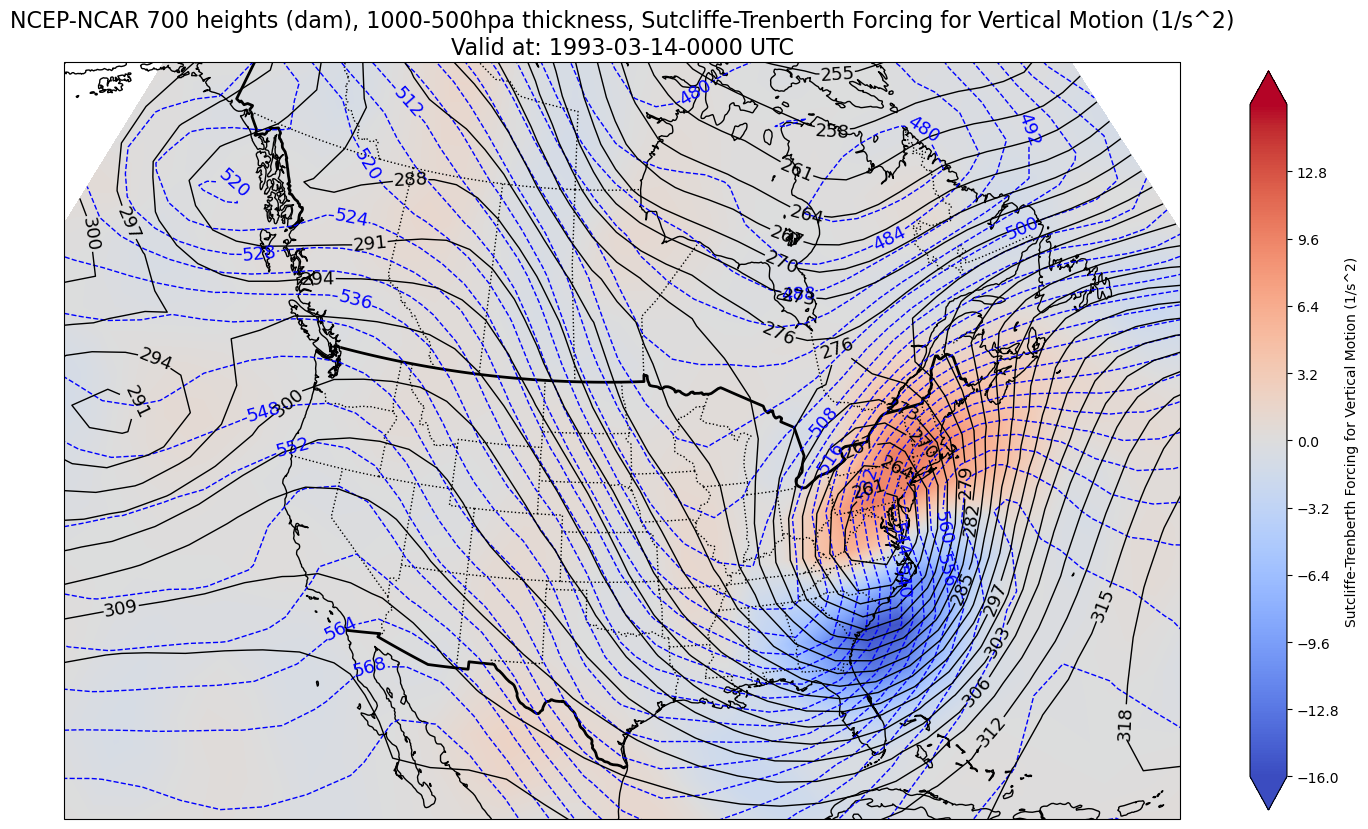

In [82]:
## Step 2: Create Cartopy object & subset data spatially & temporally

#Now that we have a handle to the data, let's create a Cartopy object to plot the data with, and subset the data spatially & temporally to reduce the memory footprint.

#Create a Lambert conformal projection object, centered over the US
lon = -98.5
lat = 38.
slat = 38.
proj_lcc = ccrs.LambertConformal(central_longitude=lon,
                             central_latitude=lat,
                             standard_parallels=[slat])

#Define geographic bounds for plot & data subsetting (this domain covers North America)
lonW,lonE,latS,latN = [-150+360, -45+360, 15, 70]

#Choose pressure level
level = 700 #FILL HERE
level2 = 500
level3 = 1000

#Subset data by time, pressure level, latitude & longitude
#Hint: You'll want to create a range of latitudes and longitudes using the geographic bounds defined above
dates = np.arange(sdate,edate,interval_hours) #Create a range of dates using the time interval previously specified
data_subset = data.sel(time=dates,PRES=level,lat=slice(latS,latN),lon=slice(lonW,lonE))
data_subset2 = data.sel(time=dates,PRES=level2,lat=slice(latS,latN),lon=slice(lonW,lonE))
data_subset3 = data.sel(time=dates,PRES=level3,lat=slice(latS,latN),lon=slice(lonW,lonE))

#Check the content of the subset data array to ensure it's what we want
#Output below should contain 3 dimensions (time, latitude, longitude)
data_subset

## Step 3: Loop through data & generate plots

#Loop through the subset data object and generate the desired plot for each time step.

#Get lats, lons, and time steps for the subset data
#Recall from ATM 350 that you load variables into memory by adding ".values"
#(e.]pg., to load a variable called "temp", type "data_subset.temp.values")
lat = data_subset.lat.values
lon = data_subset.lon.values


times = pd.to_datetime(data_subset.time.values)

#Loop through date range
for time_step in times:
    
    #Check current time stamp
    print(f"Plotting time stamp {time_step}")
    
    #Create figure and axis
    fig = plt.figure(figsize=(18,12))
    ax = fig.add_subplot(1,1,1,projection=proj_lcc)
    ax.set_extent([lonW+18,lonE-18,latS+4,latN-7])
    
    #Add geography features (coastlines, countries, states, etc.)
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(cfeat.BORDERS, linewidths=2, edgecolor='black')
    state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                             name='admin_1_states_provinces_lines',
                             scale='50m', facecolor='none')
    ax.add_feature(state_boundaries, linestyle=':',linewidths=1,edgecolor='black')

    u = data_subset.UREL_PRES.sel(time=time_step)
    v = data_subset.VREL_PRES.sel(time=time_step)
    g = data_subset.HGHT_PRES.sel(time=time_step)
    
    u2 = data_subset2.UREL_PRES.sel(time=time_step)
    u3 = data_subset3.UREL_PRES.sel(time=time_step)
    v2 = data_subset2.VREL_PRES.sel(time=time_step)
    v3 = data_subset3.VREL_PRES.sel(time=time_step)
    
    
    g2 = data_subset2.HGHT_PRES.sel(time=time_step)
    g3 = data_subset3.HGHT_PRES.sel(time=time_step)
    
    #Load each variable into memory & assign it metpy units (m/s for wind and m for height)
    u = u.values * units('m/s')
    v = v.values * units('m/s')
    g = g.values * units('m')
    
    u2 = u2.values * units('m/s')
    v2 = v2.values * units('m/s')
    
    u3 = u3.values * units('m/s')
    v3 = v3.values * units('m/s')
    
    g2 = g2.values * units('m')
    g3 = g3.values * units('m')

    
   
    #Convert height from m to dam
    height = g/10
    height2 = g2/10
    height3 = g3/10
    
     #Calculate and Plot Thickness
    g1000 = data_subset3.HGHT_PRES.sel(time=time_step).values * units('m')
    g500 = data_subset2.HGHT_PRES.sel(time=time_step).values * units('m')
    
    thickness = (g500 - g1000) / 10 
    
    cint_thickness = np.arange(0, 600, 4)
    CS_thickness = ax.contour(lon, lat, thickness, cint_thickness, linewidths=1, linestyles='dashed', colors='blue', transform=ccrs.PlateCarree())
    ax.clabel(CS_thickness, inline=1, fontsize=13, fmt='%.0f')
   

    
    #Plot height contours & labels
    cint = np.arange(0,400,3)
    CS = ax.contour(lon,lat,height,cint,linewidths=1,colors='black',linestyles='solid',transform=ccrs.PlateCarree())
    ax.clabel(CS, inline=1, fontsize=13,fmt='%.0f')

 
    
    #Convert 1D latitude and longitude arrays to 2 dimensions
    lon2d,lat2d = np.meshgrid(lon,lat)
    
    
    #Convert the latitude array from degrees to radians such that it can be used to calculate coriolis.
    lat2d_for_coriolis = np.radians(lat2d)
    
    
    #Calculate the coriolis force at all gridpoints, and horizontal distance between gridpoints
    coriolis = diag.coriolis_parameter(np.radians(lat2d))
    dx,dy = diag.lat_lon_grid_deltas(lon,lat)
    

  
    
    
    #Calculating geostrophic wind
    gwu3, gwv3 = diag.geostrophic_wind(g3, dx, dy, lat2d_for_coriolis)
    
    gwu2, gwv2 = diag.geostrophic_wind(g2, dx, dy, lat2d_for_coriolis)
    
    gwu, gwv = diag.geostrophic_wind(g, dx, dy, lat2d_for_coriolis)
   
    #thermal wind
    thermalwindu= gwu2 - gwu3
    thermalwindv= gwv2 - gwv3

    #Calculating absolute vorticity
    absolutevorticity = diag.absolute_vorticity(gwu, gwv, dx, dy, lat2d_for_coriolis)
    #vorticity = diag.vorticity(gwu, gwv, dx=dx, dy=dy)
    
    #abs Vorticity advection by thermal wind
    absvorticity_advectionbythermalwind = diag.advection(absolutevorticity, u=thermalwindu, v=thermalwindv, dx=dx, dy=dy)
                                                                                                                    
    
    
    
    #fint=np.arange(-10,10,1)
    #CF_absolutevorticity = ax.contourf(lon, lat, differential_abs_vort_adv, fint, cmap=plt.get_cmap('coolwarm'), transform=ccrs.PlateCarree(), extend='both')
    #cbar_absolutevorticity = fig.colorbar(CF_absolutevorticity, shrink=0.8, label='Absolute Vorticity (1/s)')
    

    # Create a contour plot for 
    cint_vtwa = np.arange(-16, 16, 0.01)  # Adjust contour levels as needed
    CF_vtwa = ax.contourf(lon, lat, absvorticity_advectionbythermalwind*(10**9), cint_vtwa, cmap=plt.get_cmap('coolwarm'), transform=ccrs.PlateCarree(), extend='both')
    cbar_vtwa = fig.colorbar(CF_vtwa, shrink=0.8, label='Sutcliffe-Trenberth Forcing for Vertical Motion (1/s^2)')
    
   
    
    #Create plot title
    valTime = time_step.strftime("%Y-%m-%d-%H%M UTC")
    tl1 = str("NCEP-NCAR " + str(level)+ " heights (dam), 1000-500hpa thickness, Sutcliffe-Trenberth Forcing for Vertical Motion (1/s^2)")
    tl2 = str('Valid at: '+valTime)
    plt.title(tl1+'\n'+tl2,fontsize=16)
    
    #Save or show figure
    fname = time_step.strftime("%Y%m%d%H")
    plt.savefig(fname,dpi=125)
    plt.show()
    
    #Close figure
    plt.close()

#Close the handle to the data
data.close()



In [63]:
#stfvm

In [ ]:
#thickness

In [70]:
cva=vorticity_advectionbythermalwind *(10**9)

In [32]:
#absolutevorticity

In [71]:
cva.max()

10.266284406017547 <Unit('1 / second ** 2')>

In [72]:
cva.min()

-15.491860551930522 <Unit('1 / second ** 2')>

In [78]:
#thermalwindu

In [79]:
#thermalwindv